**Тема проекта**: идентификация реплик персонажа японской визуальной новеллы (на примере Юмэми из *Planetarian: Chiisana Hoshi no Yume* (https://vndb.org/v34) и *Planetarian: Snow Globe* (https://vndb.org/v27747)).

**Задача**: построить модель бинарной классификации, которая по тексту реплики предсказывает, принадлежит ли она Юмэми.


#### Часть 1. Предобработка текста первой визуальной новеллы
##### 1.1. Конвертация txt-файла с размеченным по ролям текстом визуальной новеллы *Planetarian: Chiisana Hoshi no Yume* в csv.

In [29]:
import csv

input_file = 'planetarian_2004_with_roles.txt'
output_file = 'planetarian_2004_with_roles.csv'

with open(input_file, 'r', encoding='shift_jis') as txtfile, \
     open(output_file, 'w', encoding='utf-8', newline='') as csvfile:
    
    writer = csv.writer(csvfile)
    writer.writerow(['character', 'type', 'text'])  # заголовки в csv

    for line in txtfile:
        parts = line.split(',', 2)
        if len(parts) == 3:
            writer.writerow([p.strip() for p in parts])
            
# line.split() удаляет пробелы и \n, \r в начале и конце строки
# .split(',', 2) разбивает строку на максимум три части по двум запятым
# если после разбивки получилось 3 поля, записываем в csv как строку

In [30]:
import pandas as pd

df = pd.read_csv('planetarian_2004_with_roles.csv', encoding='utf-8')

print(df.info)

print(f"\n{df.isnull().sum()}") # проверка на NA
print(f"\nПерсонажи первой игры: {df['character'].unique()}")

<bound method DataFrame.info of         character       type                           text
0          Yumemi   dialogue            「…プラネタリウムはいかがでしょう？」
1          Yumemi   dialogue  「どんな時も決して消えることのない、美しい無窮のきらめき」
2          Yumemi   dialogue          「満天の星々がみなさまをお待ちしています」
3          Yumemi   dialogue            「プラネタリウムはいかがでしょう？…」
4          Yumemi   dialogue                 「おめでとうございますっ！」
...           ...        ...                            ...
2766  Protagonist  narration                  懐には、彼女の心があった。
2767  Protagonist  narration                      俺は歩きはじめた。
2768  Protagonist  narration                    星はどこにあるだろう？
2769  Protagonist  narration               どこに行けば、星が見えるだろう？
2770  Protagonist  narration    壊れた世界のただ中で、俺はそんなことを考え続けていた。

[2771 rows x 3 columns]>

character    0
type         0
text         0
dtype: int64

Персонажи первой игры: ['Yumemi' 'Protagonist' 'Other']


##### 1.2. Предобработка текста: очистка от пунктуации

Глаголы, частицы и вспомогательные глаголы японского языка формируют сложные конструкции, которые часто неправильно разбиваются при использовании n-грамм. Такие модели слабо учитывают контекст и синтаксис. Кроме того, форма вежливости в японском проявляется не только в отдельных токенах, но и в устойчивых связках.

Попытки токенизации и синтаксического парсинга не привели к такому разбиению предложений, которое было бы полезным для дальнейшей обработки. Поэтому на этапе предобработки мы ограничимся очисткой текста от пунктуации и остальных символов, кроме японских слоговых азбук и иероглифов.

In [31]:
import re
import pandas as pd
from tqdm import tqdm
import time

# Оставляем только японские символы, удаляем пунктуацию, цифры и т.д.
def clean_text(text):
    text = re.sub(r'[^\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF]', '', text)
    return text

csv_path = r"planetarian_2004_with_roles.csv"

df = pd.read_csv(csv_path)
text_column = 'text'

start_time = time.time()

# Очищаем текст
tqdm.pandas()
df[text_column] = df[text_column].progress_apply(lambda x: clean_text(str(x)))

# Удаляем строки, в которых после очистки не осталось текста
before = len(df)
df = df[df[text_column].str.strip() != ""]
after = len(df)
print(f"Удалено строк: {before - after}, осталось: {after}")

# Сохраняем csv-файл
df.to_csv(r"planetarian_2004_cleaned.csv", index=False)

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Считаем количество реплик каждого персонажа
counts = df['character'].value_counts()
print(f"\n{counts}")

# Заметный дисбаланс классов (740 Yumemi / 2020 not Yumemi)

100%|██████████| 2771/2771 [00:00<00:00, 173290.44it/s]

Удалено строк: 11, осталось: 2760
Время выполнения: 0.04 секунд

character
Protagonist    1968
Yumemi          740
Other            52
Name: count, dtype: int64


_____
#### Часть 2. Получение эмбеддингов
Наша задача — настроить такую модель, обученную на размеченных репликах из первой визуальной новеллы, которая сможет находить реплики персонажа Юмэми во второй игре.

Для этого необходима **контекстная модель**, способная учитывать окружение слов и улавливать стилистические особенности речи Юмэми — такие как вежливые формы, характерный синтаксис и лексика.
- Методы вроде TF-IDF и n-грамм не подходят, поскольку не учитывают ни грамматические конструкции, ни контекст.
- Вежливые формы, например 〜しております, критически важны для распознавания речи Юмэми, но при токенизации часто дробятся, а TF-IDF просто игнорирует их структуру.
- Хотя контекстные модели почти всегда являются семантическими, «плоские» семантические подходы вроде Word2Vec здесь не применимы, так как они не различают контекст и не чувствительны к грамматике.

В нашем случае подойдут **современные контекстные модели**, такие как BERT и его японские варианты, способные формировать семантически осмысленные представления (эмбеддинги) целых реплик. Именно такие модели будут использоваться в нашей работе.


##### 2.1. Стартовая модель из библиотеки **sentence-transformers**
Для начала воспользуемся библиотекой **sentence-transformers** от разработчиков архитектуры SBERT (sentence-BERT).
Она сильно упрощает работу с SBERT: загружаем модель одной строкой и получаем эмбеддинги реплик.

Модель **paraphrase-multilingual-MiniLM-L12-v2** — лёгкая, быстрая и мультиязычная (обучена на 50+ языках, включая японский).
- Архитектура MiniLM (меньше и быстрее, чем BERT).
- Оптимизирована под семантическое сравнение (поиск похожих предложений, кластеризация).
- Размер: ~22М параметров.

*Из минусов*:
- Может не засчитать вежливые конструкции Юмэми как важную особенность.
- Не монолингвальная модель, знает японский «поверхностно».

P.S. SentenceTransformer (включая модели MiniLM и sonoisa) по умолчанию использует батчинг, обычно с размером батча равным 32. Это означает, что при 2760 репликах получится около 87 итераций прогресс-бара — по одной на каждый батч.
Разница batch_size=1 и batch_size=32 в скорости (батчинг быстрее) и в потенциальной микроскопической разнице значений (в пределах float32 точности, и почти всегда незначительной), так что оставим стандартную настройку.

In [32]:
# pip install sentence-transformers
import pandas as pd
import time
from sentence_transformers import SentenceTransformer

start = time.time()

df = pd.read_csv("planetarian_2004_cleaned.csv")

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Преобразуем текст в список строк и получаем эмбеддинги
texts = df['text'].astype(str).tolist()
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Добавляем в датафрейм (в виде списков)
df['embedding'] = embeddings.tolist()

# Сохраняем результаты в .pkl
df.to_pickle("planetarian_with_st_embeddings.pkl")

end = time.time()
print(f"Эмбеддинги MiniLM сохранены в 'planetarian_with_st_embeddings.pkl'")
print(f"Время выполнения: {end - start:.2f} секунд")


Batches: 100%|██████████| 87/87 [00:24<00:00,  3.61it/s]


Эмбеддинги MiniLM сохранены в 'planetarian_with_st_embeddings.pkl'
Время выполнения: 29.40 секунд


##### 2.2. Вторая модель: sonoisa/sentence-bert-base-ja-mean-tokens

- Cнова из sentence-transformers.
- Учитывает японскую грамматику и стиль.
- Поддерживает вежливые конструкции и сложный синтаксис.
- Выдаёт один вектор на реплику.

*Из минусов*:
- Работает дольше MiniLM.

In [33]:
import pandas as pd
import time
from sentence_transformers import SentenceTransformer

start = time.time()

df = pd.read_csv("planetarian_2004_cleaned.csv")

# Загружаем японскую SBERT-модель
model = SentenceTransformer("sonoisa/sentence-bert-base-ja-mean-tokens")

# Получаем эмбеддинги
texts = df['text'].astype(str).tolist()
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Сохраняем эмбеддинги в новой колонке датафрейма
df['embedding'] = embeddings.tolist()

df.to_pickle("planetarian_with_sonoisa_embeddings.pkl")

end = time.time()
print(f"Эмбеддинги sonoisa сохранены в 'planetarian_with_sonoisa_embeddings.pkl'")
print(f"Время выполнения: {end - start:.2f} секунд")


No sentence-transformers model found with name sonoisa/sentence-bert-base-ja-mean-tokens. Creating a new one with mean pooling.
Batches: 100%|██████████| 87/87 [01:34<00:00,  1.08s/it]


Эмбеддинги sonoisa сохранены в 'planetarian_with_sonoisa_embeddings.pkl'
Время выполнения: 96.27 секунд


##### 2.3. Третья модель: cl-tohoku/bert-base-japanese (PyTorch)

- Отлично понимает японскую лексику, грамматику и структуру предложений.
- BERT-архитектура: улавливает контекст как слева, так и справа от слова.

*Из минусов*:
- Медленнее и требует больше памяти.
- Не входит в sentence-transformers напрямую, поэтому нужно вручную получать эмбеддинги (через transformers).

In [34]:
import pandas as pd
import torch
from transformers import BertJapaneseTokenizer, BertModel
from tqdm import tqdm
import time

def get_embeddings_batched(texts, tokenizer, model, device, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Генерация эмбеддингов"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True,
                           truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embs = outputs.last_hidden_state[:, 0, :].cpu().numpy() # CLS-токен
        embeddings.extend(cls_embs)
        
    return embeddings

def main():
    start = time.time()

    df = pd.read_csv("planetarian_2004_cleaned.csv")
    texts = df['text'].astype(str).tolist()

    # Загружаем токенизатор без морфоанализа (только BERT-токенизация)
    # bert-base-japanese обучена на subword-токенах (WordPiece)
    # Этого достаточно для генерации эмбеддингов, MeCab не нужен
    tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese",
                                                      do_word_tokenize=False)
    model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU или CPU
    model.to(device).eval()
    
    # Генерируем эмбеддинги
    embeddings = get_embeddings_batched(texts, tokenizer, model, device)

    # Сохраняем результат
    df['embedding'] = embeddings
    df.to_pickle("planetarian_with_bert_embeddings.pkl")

    print(f"Эмбеддинги BERT сохранены в 'planetarian_with_bert_embeddings.pkl'")
    print(f"Время выполнения: {time.time() - start:.2f} секунд")

main()

Генерация эмбеддингов: 100%|██████████| 87/87 [03:34<00:00,  2.47s/it]

Эмбеддинги BERT сохранены в 'planetarian_with_bert_embeddings.pkl'
Время выполнения: 217.60 секунд


##### 2.4. Сравнение эмбеддинг-моделей для задачи классификации
Класс "Yumemi" (label=1) меньше класса "not Yumemi" (label=0). Для борьбы с дисбалансом мы используем параметр логистической регрессии class_weight='balanced': ошибки на меньшем классе считаются важнее.

Далее мы более подробно остановимся на этом вопросе, а пока этого достаточно для справедливого сравнения качества разных эмбеддинг-моделей. Все модели обучаются и оцениваются на одном и том же разбиении данных с одинаковым дисбалансом и теми же метками.


==== MiniLM ====
              precision    recall  f1-score   support

  not Yumemi       0.92      0.88      0.90       404
      Yumemi       0.71      0.80      0.75       148

    accuracy                           0.86       552
   macro avg       0.82      0.84      0.83       552
weighted avg       0.87      0.86      0.86       552


==== Sonoisa ====
              precision    recall  f1-score   support

  not Yumemi       0.94      0.91      0.92       404
      Yumemi       0.77      0.84      0.80       148

    accuracy                           0.89       552
   macro avg       0.85      0.88      0.86       552
weighted avg       0.89      0.89      0.89       552


==== TohokuBERT ====
              precision    recall  f1-score   support

  not Yumemi       0.97      0.97      0.97       404
      Yumemi       0.92      0.91      0.92       148

    accuracy                           0.96       552
   macro avg       0.95      0.94      0.94       552
weighted avg   

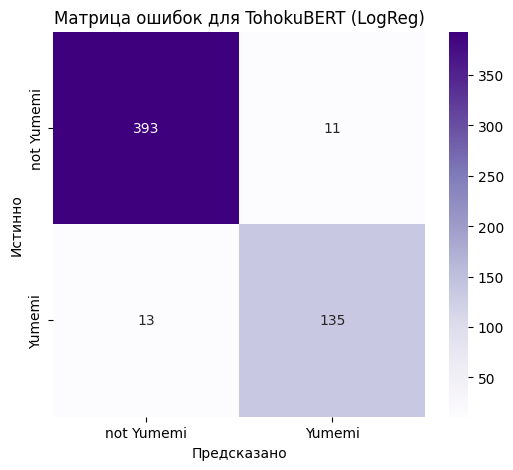

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Пути к файлам с эмбеддингами
paths = {
    "MiniLM": "planetarian_with_st_embeddings.pkl",
    "Sonoisa": "planetarian_with_sonoisa_embeddings.pkl",
    "TohokuBERT": "planetarian_with_bert_embeddings.pkl"
}

for name, path in paths.items():
    df = pd.read_pickle(path)
    
    # Метка класса: 1 — yumemi, 0 — not yumemi
    df['label'] = df['character'].apply(lambda x: 1 if str(x).strip().lower() == 'yumemi' else 0)
    
    # Признаки и целевая переменная
    X = np.stack(df['embedding'].values)
    y = df['label'].values

    # Делим на обучающую выборку и тест (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        test_size=0.2,
                                                        random_state=42)

    # Обучаем логистическую регрессию с балансом классов
    clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # Предсказания и отчёт
    y_pred = clf.predict(X_test)
    print(f"\n==== {name} ====")
    print(classification_report(y_test, y_pred,
                                target_names=["not Yumemi", "Yumemi"]))
    
    # Визуализируем матрицу ошибок для лучшей модели
    if name == "TohokuBERT":
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                    xticklabels=["not Yumemi", "Yumemi"],
                    yticklabels=["not Yumemi", "Yumemi"])
        plt.xlabel("Предсказано")
        plt.ylabel("Истинно")
        plt.title(f"Матрица ошибок для {name} (LogReg)")
        plt.show()

In [36]:
# Распределение классов
print(f"\n{name}: всего примеров — {len(df)}")
print(df['label'].value_counts())

# 404 vs 148 (552) — 20% от всего датасета


TohokuBERT: всего примеров — 2760
label
0    2020
1     740
Name: count, dtype: int64


По результатам экспериментов отлично видно, что модели сильно отличаются по качеству.
1) MiniLM (мультиязычная компактная модель):
- F-мера для Yumemi — 0.75.
- Хороший показатель для лёгкой и быстрой модели, однако она недостаточно полно учитывает особенности японского языка и контекст.
2) Sonoisa (специализированная японская Sentence-BERT модель):
- F-мера для Yumemi — 0.80.
- Модель лучше справляется с лингвистическими и стилистическими особенностями японского текста, но ещё есть потенциал для улучшения.
3) TohokuBERT (полноценная японская BERT-модель):
- F-мера для Yumemi — 0.92.
- Эта модель наиболее эффективно улавливает контекст, грамматику и стилистические нюансы языка.
- Высокие показатели точности и полноты делают её оптимальным выбором для решения нашей задачи.

_________
#### Часть 3. Классификация реплик персонажа по эмбеддингам ("Yumemi" vs "not Yumemi")

У нас уже есть готовые векторные признаки для задачи бинарной классификации, поэтому **логистическая регрессия** — это отличный базовый вариант. Она простая и интерпретируемая, быстрая на обучении и предсказании, хорошо работает при линейно разделимых классах.
Помимо неё попробуем:
- Случайный лес — устойчивый к переобучению ансамбль, работающий с нелинейными признаками.
- Градиентный бустинг (в частности, LightGBM) — метод для работы с табличными данными и эмбеддингами, показывающий высокое качество на классификационных задачах.

Работа данных моделей показана в отдельном файле "Random Forest и Gradient Boosting. ipynb".


##### Логистическая регрессия без изменения параметров (на первой визуальной новелле).

Index(['character', 'type', 'text', 'embedding'], dtype='object')
F-мера на кросс-валидации (5 фолдов): 0.906 ± 0.009
Модель сохранена в logistic_regression_model.pkl

Классификационный отчёт LogReg (первая игра):
              precision    recall  f1-score   support

  not Yumemi       0.97      0.97      0.97       404
      Yumemi       0.93      0.93      0.93       148

    accuracy                           0.96       552
   macro avg       0.95      0.95      0.95       552
weighted avg       0.96      0.96      0.96       552



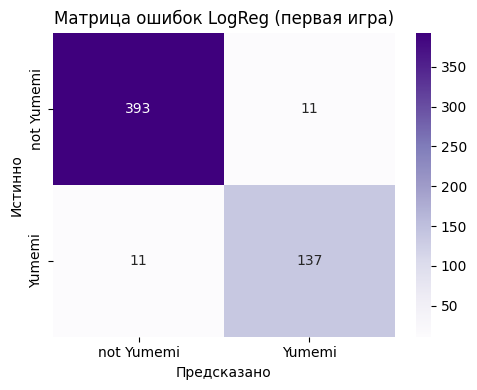

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

df = pd.read_pickle("planetarian_with_bert_embeddings.pkl")

# Проверим содержимое колонок
print(df.columns)

# Бинарная метка: 1 — yumemi, 0 — not yumemi
df['label'] = df['character'].apply(lambda x: 1 if str(x).strip().lower() == 'yumemi' else 0)

# Признаки (эмбеддинги) и метки
X = np.stack(df['embedding'].values)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# Запускаем модель логической регрессии с учётом дисбаланса классов
clf = LogisticRegression(max_iter=2000, class_weight='balanced')

# Кросс-валидация (5 фолдов), оцениваем по F-мере
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')

print(f"F-мера на кросс-валидации (5 фолдов): {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

# Учим модель на обучающей выборке
clf.fit(X_train, y_train)

# Сохраняем
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf, f)
print("Модель сохранена в logistic_regression_model.pkl")

# Предсказания вероятностей положительного класса
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

# Предсказания классов по порогу 0.47
threshold = 0.47
y_pred = (y_probs >= threshold).astype(int)

# Выводим отчёт по качеству классификации
print("\nКлассификационный отчёт LogReg (первая игра):")
print(classification_report(y_test, y_pred,
                            target_names=["not Yumemi", "Yumemi"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Purples",
    xticklabels=["not Yumemi", "Yumemi"],
    yticklabels=["not Yumemi", "Yumemi"]
)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок LogReg (первая игра)")
plt.tight_layout()
plt.show()

Результаты работы модели на тестовой выборке.

F-мера (0.906 ± 0.009) на кросс-валидации (5 фолдов) говорит о следующем:
- Модель не переобучена.
- Она обобщается хорошо на невидимые данные.
- Среднее значение и маленькое стандартное отклонение (± 0.009) указывают на стабильность модели между фолдами.

Тестовая выборка (552 объекта, 20% датасета):
- Accuracy 96%
- F-мера по классу Yumemi = 0.92
- Ошибок немного: всего 24 из 552 (4.3%)

Выводы:
- Модель научилась выделять реплики Юмэми, а не просто запомнила обучающую выборку.
- Это уже надёжная и точная модель.
- Судя по достойным результатам, умеренный дисбаланс классов (≈ 2.73:1) не мешает работе модели благодаря применению class_weight='balanced' и использованию адекватных эмбеддингов.


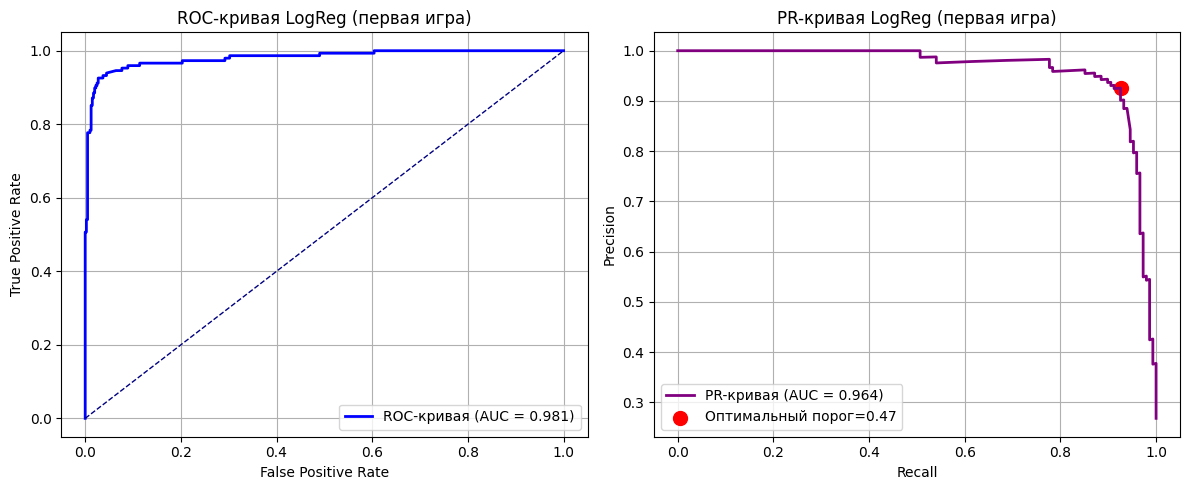

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Получаем вероятности положительного класса
y_scores = clf.predict_proba(X_test)[:, 1]

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# PR-кривая
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_precision = precision[best_idx]
best_recall = recall[best_idx]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Слева ROC
axs[0].plot(fpr, tpr, color='blue', lw=2,
            label=f'ROC-кривая (AUC = {roc_auc:.3f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC-кривая LogReg (первая игра)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Справа PR
axs[1].plot(recall, precision, color='purple', lw=2,
            label=f'PR-кривая (AUC = {pr_auc:.3f})')

# Отмечаем точку с максимальной F-мерой
axs[1].scatter(best_recall, best_precision, color='red', s=100,
               label=f'Оптимальный порог={best_threshold:.2f}')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('PR-кривая LogReg (первая игра)')
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.tight_layout()
plt.show()


Выводы о PR-кривой:
- Модель уверенно распознаёт реплики Юмэми.
- Отличный баланс между precision и recall, модель устойчива к дисбалансу классов.

#### 4. Идентификация реплик Юмэми на тестовой выборке

##### 4.1. Препроцессинг файла второй игры snow_globe_with_roles.xlsx

In [39]:
import pandas as pd
import re

df = pd.read_excel('snow_globe_with_roles.xlsx')

df.to_csv('snow_globe_with_roles.csv', index=False, encoding='utf-8-sig')

def clean_text(text):
    text = str(text)
    return re.sub(r'[^\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF]', '', text)

df['text'] = df['text'].apply(clean_text)

# Удаляем строки, где текст стал пустым после очистки
df = df[df['text'].str.strip() != '']
df.to_csv('snow_globe_cleaned.csv', index=False, encoding='utf-8-sig')
print("Файл сохранён как 'snow_globe_cleaned.csv'")

# Считаем количество строк на каждый класс
counts = df['character'].value_counts()
print(f"\n{counts}")

# 68 "Yumemi" vs  719 "not Yumemi"

Файл сохранён как 'snow_globe_cleaned.csv'

character
Narrator    420
Satomi      195
Other        83
Yumemi       68
Goro         21
Name: count, dtype: int64


##### 4.2. Генерируем эмбеддинги и применяем к тексту второй игры обученную модель логистической регрессии.

In [40]:
import pandas as pd
import torch
from transformers import BertJapaneseTokenizer, BertModel
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Загружаем модель логистической регрессии
with open("logistic_regression_model.pkl", "rb") as f:
    clf = pickle.load(f)

# Генерируем эмбеддинги BERT
def get_embeddings(texts, tokenizer, model, device):
    embeddings = []
    for text in tqdm(texts, desc="Генерация эмбеддингов"):
        inputs = tokenizer(text, return_tensors="pt", padding=True,
                           truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings.append(cls_emb)
    return np.array(embeddings)

# Загружаем модель TohokuBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese",
                                                  do_word_tokenize=False)
model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")
model.to(device)
model.eval()

# Загрузка датасета второй игры
df = pd.read_csv("snow_globe_cleaned.csv")
df['label'] = df['character'].apply(lambda x: 1 if "Yumemi" in str(x) else 0)

# Делим датасет на валидацию и тест (10/90)
df_val, df_test = train_test_split(df, test_size=0.90, stratify=df['label'],
                                   random_state=42)

# Генерируем эмбеддинги для валидации и теста
X_val = get_embeddings(df_val['text'].astype(str).tolist(),
                       tokenizer, model,device)
y_val = df_val['label'].values
X_test = get_embeddings(df_test['text'].astype(str).tolist(),
                        tokenizer, model, device)
y_test = df_test['label'].values

# Определяем лучший порог по F-мере на валидации (цель создания валидационной выборки)
val_probs = clf.predict_proba(X_val)[:, 1]
best_thresh = 0.0
best_score = 0.0

for threshold in np.arange(0.0, 1.01, 0.01):
    preds = (val_probs >= threshold).astype(int)
    score = f1_score(y_val, preds)
    if score > best_score:
        best_score = score
        best_thresh = threshold

print(f"Оптимальный порог по F-мере на валидации: {best_thresh:.2f} (F1 = {best_score:.3f})")

# Применяем порог к тесту
test_probs = clf.predict_proba(X_test)[:, 1]
y_pred_test = (test_probs >= best_thresh).astype(int)

df_test = df_test.copy()
df_test['pred_prob'] = test_probs
df_test['pred_label'] = y_pred_test


Генерация эмбеддингов: 100%|██████████| 709/709 [00:55<00:00, 12.66it/s]


Оптимальный порог по F-мере на валидации: 0.85 (F1 = 0.824)


##### 4.3. Изучаем результаты


Классификационный отчёт LogReg (вторая игра):
              precision    recall  f1-score   support

  not Yumemi       0.99      0.96      0.97       648
      Yumemi       0.67      0.89      0.76        61

    accuracy                           0.95       709
   macro avg       0.83      0.92      0.87       709
weighted avg       0.96      0.95      0.96       709



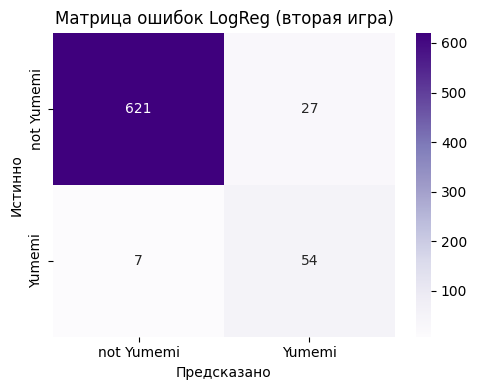


34 ошибочных примеров сохранено в 'snow_globe_test_errors_logreg.csv'.


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("\nКлассификационный отчёт LogReg (вторая игра):")
print(classification_report(y_test, y_pred_test,
                            target_names=["not Yumemi", "Yumemi"]))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["not Yumemi", "Yumemi"],
            yticklabels=["not Yumemi", "Yumemi"])
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок LogReg (вторая игра)")
plt.tight_layout()
plt.show()

# Сохраняем ошибочные примеры
df_test = df_test.copy()

# Добавляем true_label и pred_label
df_test['label'] = y_test
df_test['pred_label'] = y_pred_test

# Отбираем ошибки (где предсказание не равно истинной метке)
df_errors = df_test[df_test['label'] != df_test['pred_label']]

# Переупорядочим колонки
cols_order = ['character', 'type', 'text', 'label', 'pred_label']
df_errors = df_errors[cols_order]

df_errors.to_csv("snow_globe_test_errors_logreg.csv", index=False)

print(f"\n{len(df_errors)} ошибочных примеров сохранено в 'snow_globe_test_errors_logreg.csv'.")


- Precision для "Yumemi" (0.67): из всех предсказанных моделью как "Yumemi", 67% действительно являются таковыми. Довольно много ложных срабатываний (FP).
- Recall для "Yumemi" (0.89): модель хорошо обнаруживает почти 89% всех настоящих "Yumemi" — высокий показатель, что важно, если мы хотим минимизировать пропуски (FN).
- F-мера для "Yumemi" (0.76): гармоническое среднее между precision и recall показывает, что баланс между ошибками и пропусками лучше, чем в большинстве случаев, но ещё есть куда расти.
- Для класса "not Yumemi" precision очень высок (0.99), модель почти не ошибается, когда говорит, что это не "Yumemi". Recall чуть ниже (0.96), значит около 4% настоящих not Yumemi ошибочно помечаются как Yumemi (FN для "not Yumemi").
- Общая accuracy 0.95 — высокая точность, что отражает хорошее качество классификации при сохранении баланса.
- Macro avg (среднее по классам без учёта количества примеров) по F1 — 0.87, показывает, что модель в целом хорошо справляется и с редким, и с частым классом.

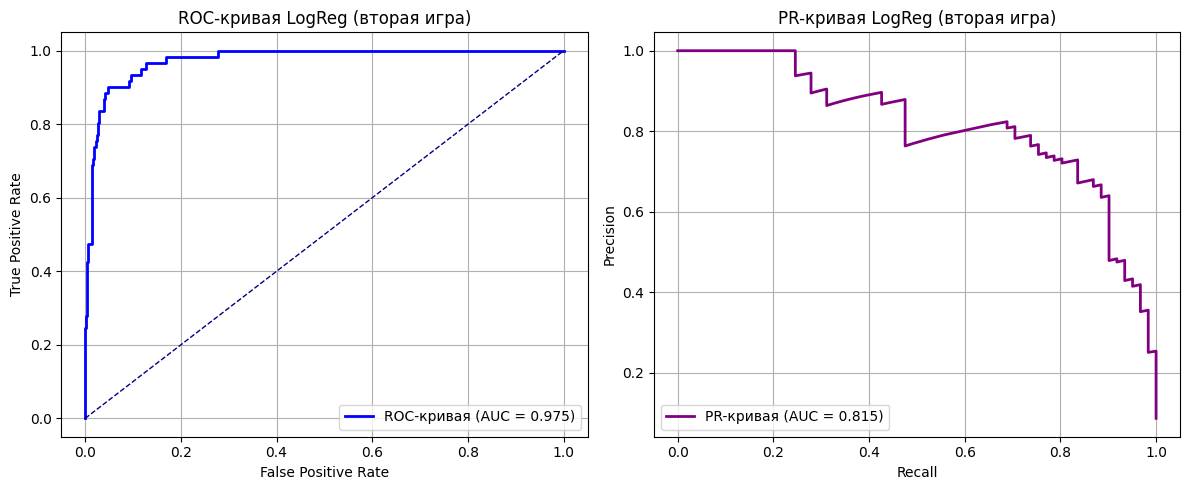

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# PR-кривая
precision, recall, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Слева ROC
axs[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.3f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC-кривая LogReg (вторая игра)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Справа PR
axs[1].plot(recall, precision, color='purple', lw=2, label=f'PR-кривая (AUC = {pr_auc:.3f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('PR-кривая LogReg (вторая игра)')
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.tight_layout()
plt.show()


1) ROC-кривая слабо зависит от дисбаланса классов (FPR считает только негативные классы).
2) PR-кривая очень чувствительна к дисбалансу классов. Кривая выглядит «рваной» из-за того, что precision падает при росте recall (положительного класса мало).

____________
##### 4.5. Выводы о работе модели логистической регрессии

Модель логистической регрессии служит хорошей отправной точкой, и в дополнительном файле «Random Forest и Gradient Boosting.ipynb» мы планируем исследовать более сложные алгоритмы и методы балансировки классов, чтобы сравнить их эффективность с текущей базовой моделью.